# Normalization of CMIP climate data

In [1]:
import numpy as np
import pandas as pd
import h5py
from scipy.stats import linregress
from mce.core import ScenarioBase

In [ ]:
ds = ScenarioBase(outpath='data/calib_cmip.h5')

## Input "stitched" global mean data

In [3]:
map_units = {
    'rtnt': 'W m-2',
    'tas': 'K',
    'time': 'yr',
}

In [ ]:
path = 'datain/cmip5_global_mean.h5'
with h5py.File(path, mode='r') as h5f:
    for source_id, g1 in h5f.items():
        for experiment, g2 in g1.items():
            grp = ds.file.create_group(f'calib/CMIP5/{source_id}/{experiment}/raw')
            for k, v in g2.items():
                k = k.replace('year', 'time')
                dset = grp.create_dataset(k, data=v[:])
                dset.attrs['units'] = map_units[k]

In [5]:
path = 'datain/cmip6_global_mean.h5'
with h5py.File(path, mode='r') as h5f:
    for source_id, g1 in h5f.items():
        for experiment_id, g2 in g1.items():
            grp = ds.file.create_group(f'calib/CMIP6/{source_id}/{experiment_id}/raw')
            for k, v in g2.items():
                k = k.replace('year', 'time')
                dset = grp.create_dataset(k, data=v[:])
                dset.attrs['units'] = map_units[k]

## Normalization

In [6]:
def reg_polyfit(d1):
    """Linear regression by numpy.polyfit

    Parameters
    ----------
    d1
        Input data in pandas.Series

    Returns
    -------
        Regression coefficients of slope and intercept
    """
    p = np.polyfit(d1.index, d1, 1)
    return p[0], p[1]


def reg_linregress(d1):
    """Linear regression by scipy.stats.linregress

    Parameters
    ----------
    d1
        Input data in pandas.Series

    Returns
    -------
        Regression coefficients of slope and intercept
    """
    reg = linregress(d1.index, d1)
    return reg.slope, reg.intercept
    

class LinearRegression:
    def __init__(self, f_regress):
        """Linear regression class

        Parameters
        ----------
        f_regress
            Regression function
        """
        self.f_regress = f_regress
        self.slope = None
        self.intercept = None

    def regress(self, d1, ret=True):
        """Perform regression

        Parameters
        ----------
        d1
            Input data in pandas.Series
        ret, optional
            Return fitting data when True, by default True

        Returns
        -------
            Fitting data in pandas.Series
        """
        self.slope, self.intercept = self.f_regress(d1)
        if ret:
            return self.trend(d1)
        
    def trend(self, d1):
        """Fitting to given data

        Parameters
        ----------
        d1
            Input data in pandas.Series

        Returns
        -------
            Fitting data in pandas.Series
        """
        return pd.Series(
            self.slope * d1.index.values + self.intercept,
            index=d1.index,
        )

In [7]:
# use linear regression
linreg = LinearRegression(reg_linregress)

### CMIP5

In [8]:
map_slice = {
    'abrupt4xCO2': slice(None, 150),
    '1pctCO2': slice(None, 140),
    'piControl': slice(None, None),
}
map_slice_specific = {
    # add 1 year to discard the first December-only year
    ('HadGEM2-ES', 'abrupt4xCO2'): slice(None, 151),
    ('HadGEM2-ES', '1pctCO2'): slice(None, 151),
}

In [ ]:
for source_id, g1 in ds.file['calib/CMIP5'].items():
    df = {}

    for experiment_id, g2 in g1.items():
        slc = map_slice_specific.get(
            (source_id, experiment_id),
            map_slice[experiment_id],
        )
        # Ensure to use the same length across variables
        dlen = min([len(v) for v in g2['raw'].values()])

        df[experiment_id] = (
            pd.DataFrame({k: v[:dlen][slc] for k, v in g2['raw'].items()})
            .set_index('time')
        )

    df = pd.concat(df, axis=1).sort_index()

    # Truncate the period to cover all experiments at least
    # The truncated length is typically 150 years, but can be longer depending on branch times
    if df.shape[1] == 4:
        # 1pctCO2 may be missing
        df = df.dropna()
    else:
        d1 = df.apply(lambda d1: len(d1.dropna()), axis=1) < 4
        (i0, i1) = (d1.idxmin(), d1.iloc[::-1].idxmin())
        df = df.loc[i0:i1]

    if source_id == 'HadGEM2-ES':
        # Shift 1 year to discard the first December-only year for abrupt4xCO2 and 1pctCO2
        df = pd.concat([
            d1.shift(-1).dropna() if k[0] != 'piControl' else d1.iloc[:-1]
            for k, d1 in df.items()
        ], axis=1)

    data = {}
    attrs = {}

    for variable_id, df1 in df.groupby(axis=1, level=1):
        df1 = df1.droplevel(axis=1, level=1)
        # Linear regression to make the trend of the control run
        trend = linreg.regress(df1['piControl'])
        attrs[variable_id] = {'slope': linreg.slope, 'intercept': linreg.intercept}
        # Subtract the trend from each scenario data
        for experiment_id, d1 in df1.sub(trend, axis=0).items():
            d = data.setdefault(experiment_id, {})
            d[variable_id] = d1

    # Save detrended data with trend attributes
    for experiment_id, data1 in data.items():
        # Use 'norm1' for normalization with this configuration
        grp = g1[experiment_id].create_group('norm1')
        for variable_id, d1 in pd.DataFrame(data1).reset_index().dropna().items():
            dset = grp.create_dataset(variable_id, data=d1.values)
            dset.attrs['units'] = map_units[variable_id]
            for k, v in attrs.get(variable_id, {}).items():
                dset.attrs[k] = v

### CMIP6

In [10]:
map_slice = {
    'abrupt-4xCO2': slice(None, 150),
    '1pctCO2': slice(None, 140),
    'piControl': slice(None, None),
}
map_slice_specific = {}

In [11]:
for source_id, g1 in ds.file['calib/CMIP6'].items():
    df = {}

    for experiment_id, g2 in g1.items():
        slc = map_slice_specific.get(
            (source_id, experiment_id),
            map_slice[experiment_id],
        )
        # ensure to use the same length across variables
        dlen = min([len(v) for v in g2['raw'].values()])

        df[experiment_id] = (
            pd.DataFrame({k: v[:dlen][slc] for k, v in g2['raw'].items()})
            .set_index('time')
        )

    df = pd.concat(df, axis=1).sort_index()

    # Truncate the period to cover all experiments at least
    # The truncated length is typically 150 years, but can be longer depending on branch times
    if df.shape[1] == 4:
        # 1pctCO2 may be missing
        df = df.dropna()
    else:
        d1 = df.apply(lambda d1: len(d1.dropna()), axis=1) < 4
        (i0, i1) = (d1.idxmin(), d1.iloc[::-1].idxmin())
        df = df.loc[i0:i1]

    data = {}
    attrs = {}

    for variable_id, df1 in df.groupby(axis=1, level=1):
        df1 = df1.droplevel(axis=1, level=1)
        # Linear regression to make the trend of the control run
        trend = linreg.regress(df1['piControl'])
        attrs[variable_id] = {'slope': linreg.slope, 'intercept': linreg.intercept}
        # Subtract the trend from each scenario data
        for experiment_id, d1 in df1.sub(trend, axis=0).items():
            d = data.setdefault(experiment_id, {})
            d[variable_id] = d1

    # Save detrended data with trend attributes
    for experiment_id, data1 in data.items():
        # Use 'norm1' for normalization with this configuration
        grp = g1[experiment_id].create_group('norm1')
        for variable_id, d1 in pd.DataFrame(data1).reset_index().dropna().items():
            dset = grp.create_dataset(variable_id, data=d1.values)
            dset.attrs['units'] = map_units[variable_id]
            for k, v in attrs.get(variable_id, {}).items():
                dset.attrs[k] = v

In [12]:
ds.close()

[2025-04-05 11:28:08 mce.core] INFO:file untracked/calib_cmip.h5 closed


### Plot results of an example model

In [ ]:
from mce.util.plot_base import PlotBase

In [14]:
myplt = PlotBase(palette='ipcc_wg1')

In [15]:
ds = ScenarioBase(outpath='untracked/calib_cmip.h5', mode='r')

[2025-04-05 11:29:31 mce.core] INFO:untracked/calib_cmip.h5 already exists
[2025-04-05 11:29:31 mce.core] INFO:file untracked/calib_cmip.h5 opened with mode=r


In [22]:
cmip_era = 'CMIP6'
source_id = 'MIROC-ES2L'
list(ds.file[f'calib/{cmip_era}/{source_id}'])

['1pctCO2', 'abrupt-4xCO2', 'piControl']

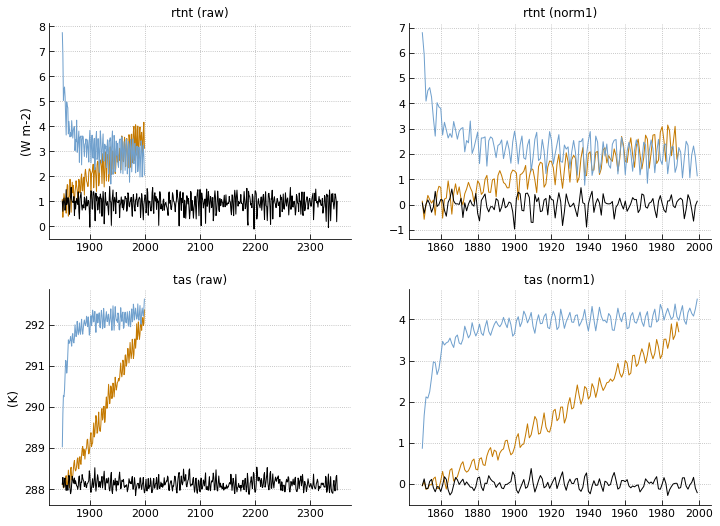

In [31]:
cmip_era = 'CMIP6'
source_id = 'MIROC-ES2L'

myplt.init_regular(4, col=2)

map_color = {
    '1pctCO2': 'C2',
    'abrupt-4xCO2': 'C1',
    'piControl': 'C0',
}
variables = ['rtnt', 'tas']

for exp1, grp in ds.file[f'calib/{cmip_era}/{source_id}'].items():
    color = map_color[exp1]
    for i, variable_id in enumerate(variables):
        df = pd.DataFrame({k: v for k, v in grp['raw'].items()}).set_index('time')
        ax = myplt(2*i)
        d1 = df[variable_id]
        ax.plot(d1.index, d1, color=color)
        ax.set_ylabel('({})'.format(grp['raw'][variable_id].attrs['units']))
        ax.set_title(f'{variable_id} (raw)')

        df = pd.DataFrame({k: v for k, v in grp['norm1'].items()}).set_index('time')
        ax = myplt(2*i+1)
        d1 = df[variable_id]
        ax.plot(d1.index, d1, color=color)
        ax.set_title(f'{variable_id} (norm1)')

for ax in myplt():
    ax.grid()

In [ ]:
ds.close()